In [1]:
import random
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
import copy
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

# Модель сети

In [2]:
# Некоторые функции для определения положения детекторов излучения 
detector_pos = [
    (46 , 66, 46 , 66), (46 , 66, 93 , 113), (46 , 66, 140 , 160),
    (85 , 105, 46 , 66), (85 , 105, 78 , 98), (85 , 105, 109 , 129),
    (85 , 105, 140 , 160), (125 , 145, 46 , 66), (125 , 145, 93 , 113),
    (125 , 145, 140 , 160)
  ]

def generate_det_row(det_size, start_pos_x, start_pos_y, det_step, N_det):
  p = []
  for i in range(N_det):
    left = start_pos_x+i*(int(det_step)+det_size)
    right = left + det_size
    up = start_pos_y
    down = start_pos_y + det_size
    p.append((up, down, left, right))
  return p

def set_det_pos(det_size=20, start_pos_x = 46, start_pos_y = 46):
  p = []
  p.append(generate_det_row(det_size, start_pos_x, start_pos_y, 2*det_size, 3))
  p.append(generate_det_row(det_size, start_pos_x, start_pos_y+3*det_size, 1*det_size, 4))
  p.append(generate_det_row(det_size, start_pos_x, start_pos_y+6*det_size, 2*det_size, 3))
  return list(itertools.chain.from_iterable(p))

def detector_region(x):
  detectors_list = []
  full_int = x.sum(dim=(1,2))
  for det_x0, det_x1, det_y0, det_y1 in detector_pos:
    detectors_list.append((x[:, det_x0 : det_x1+1, det_y0 : det_y1+1].sum(dim=(1, 2))/full_int).unsqueeze(-1))
  return torch.cat(detectors_list, dim = 1)

In [3]:
# Реализация расчета распространения излучения на PyTorch
class DiffractiveLayer(torch.nn.Module):

    def __init__(self, λ = 532e-9, N_pixels = 400, pixel_size = 20e-6, dz = 0.01):
        super(DiffractiveLayer, self).__init__()

        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy)

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        #Calculate the propagating and the evanescent (complex) modes
        tmp = np.sqrt(np.abs(argument))
        kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp))
        self.phase = torch.exp(1j * kz * dz).to(device)

    def forward(self, E):
        # waves (batch, 200, 200)
        fft_c = torch.fft.fft2(E)
        c = torch.fft.fftshift(fft_c)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * self.phase))
        return angular_spectrum

In [4]:
# Фазовая маска + дифракционный слой
class PhaseLayer(torch.nn.Module):

  def __init__(self, λ = 532e-9, N_pixels = 400, pixel_size = 20e-6, dz = 0.01, phase_mask = None):
    super(self).__init__()
    self.difractive_layer = DiffractiveLayer(λ, N_pixels, pixel_size, dz)

    if phase_mask is None:
      self.phase_mask = torch.nn.Parameter(torch.zeros((N_pixels, N_pixels)).astype('float32'))
    else:
      self.phase_masl = torch.nn.Parameter(phase_mask)

  def forward(self, E):
    constr_phase = np.pi*torch.sigmoid(self.phase_mask)
    return self.difractive_layer(E)*torch.exp(1j*constr_phase)

In [5]:
# Архитектура Фурье дифракционной сети
class Fourier_DNN(torch.nn.Module):
    """
    phase only modulation
    """
    def __init__(self, num_layers=5, wl = 532e-9, N_pixels = 400, pixel_size = 20e-6, distance = 0.01, lens_focus = 10e-2):

        super(Fourier_DNN, self).__init__()
        
        #self.phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).astype('float32')-0.5)) for _ in range(num_layers)]
        self.phase = [torch.nn.Parameter(torch.from_numpy(np.zeros((N_pixels, N_pixels)).astype('float32'))) for _ in range(num_layers)]
        for i in range(num_layers):
            self.register_parameter("phase" + "_" + str(i), self.phase[i])

        coord_limit = (N_pixels//2)*pixel_size 
        mesh = np.arange(-coord_limit, coord_limit, pixel_size)
        x, y = np.meshgrid(mesh, mesh)    
        self.lens_phase = torch.tensor(np.exp(-1j*np.pi/(wl*2*lens_focus) * (x**2 + y**2)), device = device)
        self.first_diffractive_layer = DiffractiveLayer(wl, N_pixels, pixel_size, lens_focus-distance)
        self.diffractive_layers = torch.nn.ModuleList([DiffractiveLayer(wl, N_pixels, pixel_size, distance) for _ in range(0,num_layers)])
        self.double_f_layer = DiffractiveLayer(wl, N_pixels, pixel_size, 2*lens_focus)
        self.single_f_layer = DiffractiveLayer(wl, N_pixels, pixel_size, lens_focus)
        self.sofmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        # x (batch, 200, 200)
        outputs = []
        outputs.append(x)
        #x = self.double_f_layer(x)
        x = self.single_f_layer(x)
        outputs.append(x)
        x = x*self.lens_phase
        x = self.first_diffractive_layer(x)
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(x)
            outputs.append(x)
            #constr_phase = self.phase[index]#
            constr_phase = np.pi*torch.sigmoid(self.phase[index])
            exp_j_phase = torch.exp(1j*constr_phase)#torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            x = temp * exp_j_phase
        x = self.single_f_layer(x)
        outputs.append(x)
        x = x*self.lens_phase
        #x = self.double_f_layer(x)
        x = self.single_f_layer(x)
        outputs.append(x)
        # x_abs (batch, 200, 200)
        x_abs = torch.abs(x)**2
        output = detector_region(x_abs)
        return output, x_abs, outputs

In [6]:
# Загрузка датасета
BATCH_SIZE = 32
IMG_SIZE = 28 * 3
N_pixels = 200
PADDING = (N_pixels - IMG_SIZE) // 2

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE,IMG_SIZE))])
train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [38]:
# Функция для тренировки дифракционной сети
def train(model, loss_function,optimizer, trainloader, testloader, epochs =10,  device='cpu'):
    train_loss_hist = []
    test_loss_hist=[]
    train_acc_hist=[]
    test_acc_hist=[]
    best_acc=0
    for epoch in range(epochs):
        ep_loss = 0
        model.train()
        correct = 0
        total = 0
        for images, labels in tqdm(trainloader):
            
            images=images.to(device)
            images = F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING))
            labels=labels.to(device)
            #det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
            #det_labels = labels_image_tensors[labels]
            
            optimizer.zero_grad() 
            out_label, out_img, _ = model(images)
            
            _, predicted = torch.max(out_label.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            full_int_img = out_img.sum(axis=(1,2))
            #loss = loss_function(out_img/full_int_img[:,None,None], det_labels)
            #loss = loss_function(out_label, det_labels)
            loss = custom_loss(out_img, labels)
            
            loss.backward() 
            optimizer.step() 
            ep_loss += loss.item()
        train_loss_hist.append(ep_loss /len(trainloader))
        train_acc_hist.append(correct /total)
        #train_acc_hist.append(validate(model, trainloader,device))

        #test_acc_hist.append(validate(model, testloader,device))
        # if test_acc_hist[-1][0]>best_acc:
        #     best_model=copy.deepcopy(model)
        
        ep_loss = 0
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(testloader):
                images=images.to(device)
                images = F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING))
                labels=labels.to(device)
                #det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
                #det_labels = labels_image_tensors[labels]

                out_label, out_img, _ = model(images)
                _, predicted = torch.max(out_label.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                full_int_img = out_img.sum(axis=(1,2))
                #loss = loss_function(out_img/full_int_img[:,None,None], det_labels)
                #loss = loss_function(out_label, det_labels)
                loss = custom_loss(out_img, labels)

                ep_loss += loss.item()
        test_loss_hist.append(ep_loss /len(testloader))
        test_acc_hist.append(correct / total)
        if test_acc_hist[-1]>best_acc:
             best_model=copy.deepcopy(model)

        print(f"Epoch={epoch} train loss={train_loss_hist[epoch]:.4}, test loss={test_loss_hist[epoch]:.4}")
        print(f"train acc={train_acc_hist[epoch]:.4}, test acc={test_acc_hist[epoch]:.4}")
        #print(f"train acc={train_acc_hist[epoch][0]:.4}, test acc={test_acc_hist[epoch][0]:.4}")
        #print(f"train f1={train_acc_hist[epoch][1]:.4}, test f1={test_acc_hist[epoch][1]:.4}")
        print("-----------------------")
        
    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model

In [11]:
#N_pixels = 200
pixel_size = 10e-6 #m
wl = 532e-9 #m 
distance_between_layers = 5e-3

In [12]:
det_size = 20
det_pad = (N_pixels - 7*det_size)//2
detector_pos = set_det_pos(det_size, det_pad, det_pad)

In [22]:
labels_image_tensors=torch.zeros((10,N_pixels,N_pixels), device = device, dtype = torch.double)
for ind,pos in enumerate(detector_pos):
  pos_l, pos_r, pos_u, pos_d = pos
  labels_image_tensors[ind,pos_l+1:pos_r+1, pos_u+1:pos_d+1] = 1
  labels_image_tensors[ind] = labels_image_tensors[ind]#/labels_image_tensors[ind].sum()

In [23]:
detector_region(labels_image_tensors)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0',
       dtype=torch.float64)

In [43]:
def custom_loss(imgs, labels):
  full_int = imgs.sum(dim=(1,2))
  loss = 1 - (imgs*labels_image_tensors[labels]).sum(dim=(1,2))/full_int
  return loss.mean()

In [32]:
custom_loss(b[None,:], [0])

tensor([-0.9000], device='cuda:0', dtype=torch.float64)

In [28]:
b = labels_image_tensors.sum(axis = 0)

In [35]:
custom_loss(labels_image_tensors, [1,1,0,0,0,0,0,0,0,0])

tensor([-1.,  0., -1., -1., -1., -1., -1., -1., -1., -1.], device='cuda:0',
       dtype=torch.float64)

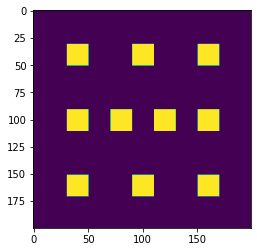

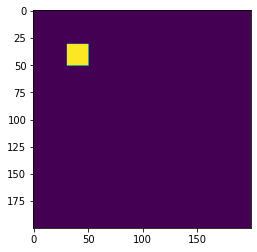

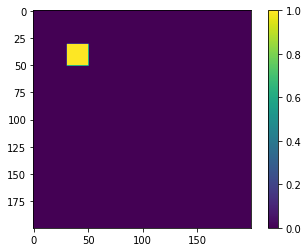

In [25]:
a = labels_image_tensors.cpu().numpy().sum(axis = 0)
plt.imshow(a)
plt.show()
plt.imshow(labels_image_tensors.cpu().numpy()[0])
plt.show()
plt.imshow(a*labels_image_tensors.cpu().numpy()[0])
plt.colorbar()

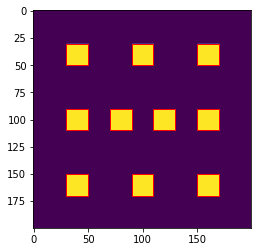

In [15]:
plt.imshow(labels_image_tensors.cpu().numpy().sum(axis = 0))
for det in detector_pos:
  rect = patches.Rectangle((det[2], det[0]), det_size, det_size, linewidth=1, edgecolor='r', facecolor='none')
  plt.gca().add_patch(rect)
plt.show()

In [44]:
f = 100e-3
model = Fourier_DNN(5, wl, N_pixels, pixel_size, distance_between_layers, f).to(device)
#criterion = torch.nn.MSELoss(reduction='sum').to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
#criterion = custom_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

phase_0 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
phase_1 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
phase_2 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
phase_3 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  

In [45]:
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = train(model, 
                          criterion,optimizer, train_dataloader, val_dataloader, epochs = 7,  device = device)

100%|██████████| 313/313 [00:13<00:00, 23.00it/s]


Epoch=0 train loss=0.8546, test loss=0.8129
train acc=0.4002, test acc=0.4918
-----------------------


100%|██████████| 313/313 [00:13<00:00, 23.15it/s]


Epoch=1 train loss=0.8073, test loss=0.8009
train acc=0.5068, test acc=0.5128
-----------------------


100%|██████████| 313/313 [00:13<00:00, 23.08it/s]


Epoch=2 train loss=0.8001, test loss=0.7964
train acc=0.5169, test acc=0.529
-----------------------


100%|██████████| 313/313 [00:13<00:00, 23.05it/s]


Epoch=3 train loss=0.7968, test loss=0.7941
train acc=0.5226, test acc=0.5249
-----------------------


100%|██████████| 313/313 [00:13<00:00, 23.02it/s]


Epoch=4 train loss=0.7949, test loss=0.7925
train acc=0.5256, test acc=0.5237
-----------------------


100%|██████████| 313/313 [00:13<00:00, 23.04it/s]


Epoch=5 train loss=0.7936, test loss=0.7915
train acc=0.5271, test acc=0.527
-----------------------


 99%|█████████▉| 1862/1875 [02:13<00:00, 13.90it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model, 'Fourier_MNIST_0.77.pth')

In [ ]:
def visualize(example, draw_detectors = True):
  ex = F.pad(example[0], pad=(PADDING, PADDING, PADDING, PADDING))
  out = model(ex.to(device))
  plt.imshow(ex[0], interpolation='none')
  plt.title(f'Input image label {example[1]}')
  plt.show()
  output_image = out[1].detach().cpu()[0]
  _, out_label = torch.max(out[0].data, 1)
  plt.imshow(output_image, interpolation='none')
  #plt.title(f'Output image with total_int {output_image.sum():.2f}')
  plt.title(f'Output image label {out_label.item()}')
  plt.colorbar()
  if draw_detectors:
    for det in detector_pos:
      rect = patches.Rectangle((det[2], det[0]), det_size, det_size, linewidth=1, edgecolor='r', facecolor='none')
      plt.gca().add_patch(rect)
  plt.show()

def mask_visualiztion():
  for ind, mask in enumerate(model.phase):
    plt.imshow(torch.sigmoid(mask.detach().cpu())*360, interpolation = 'none')
    #plt.imshow(mask.detach().cpu()*180/np.pi, interpolation='none')
    plt.title(f'Mask of layer {ind+1}')
    plt.colorbar()
    plt.show()

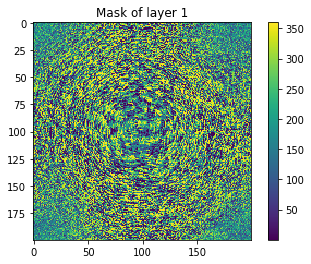

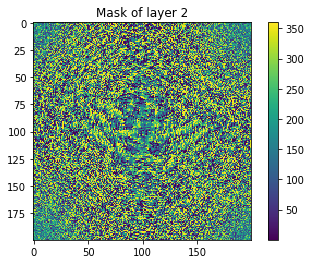

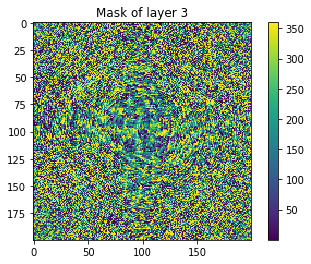

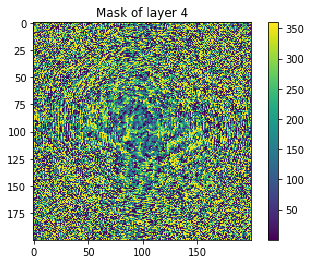

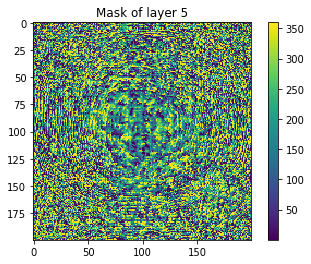

In [ ]:
mask_visualiztion()

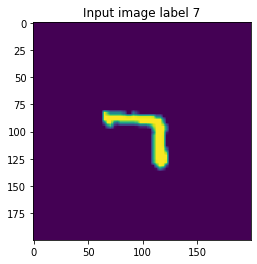

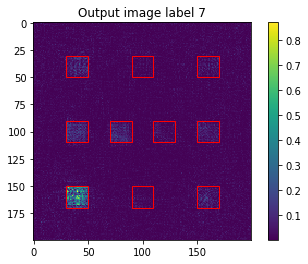

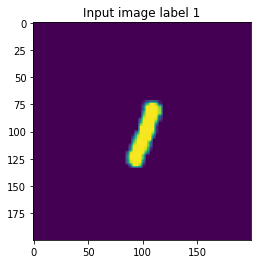

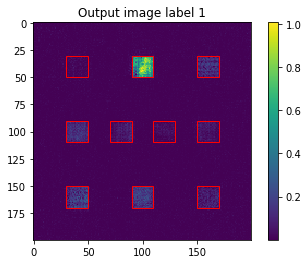

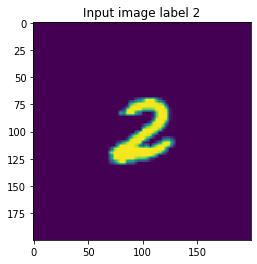

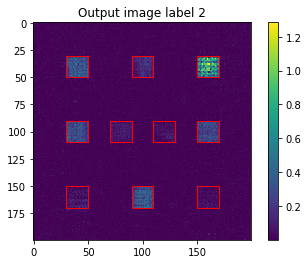

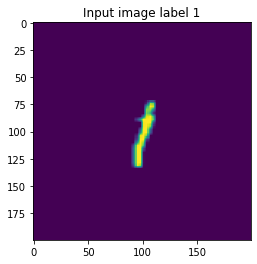

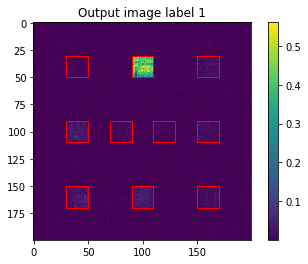

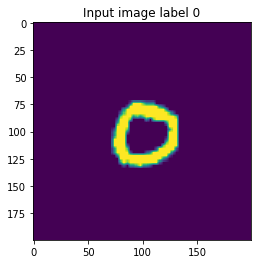

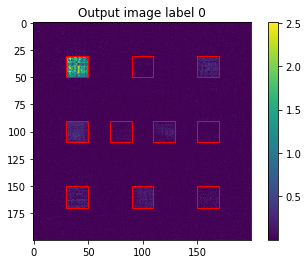

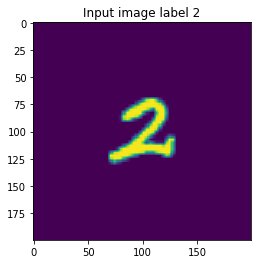

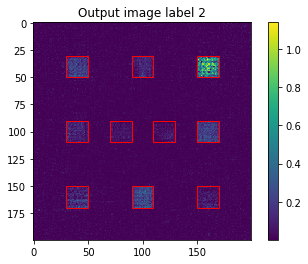

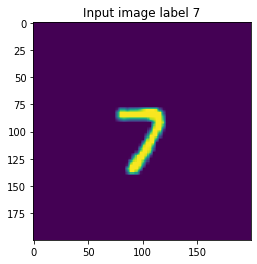

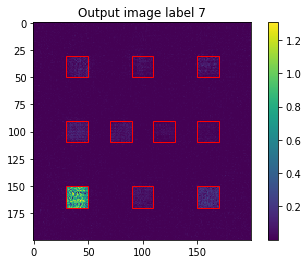

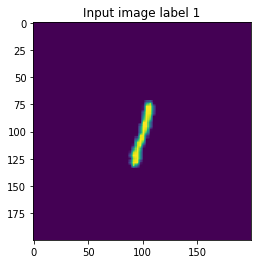

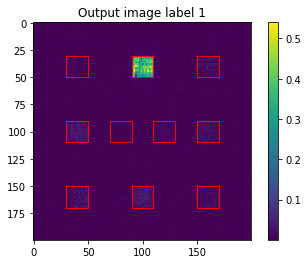

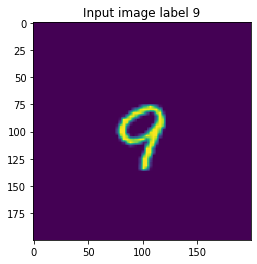

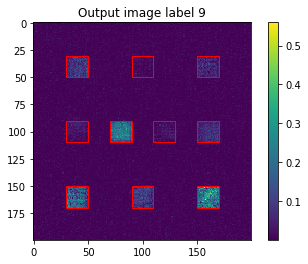

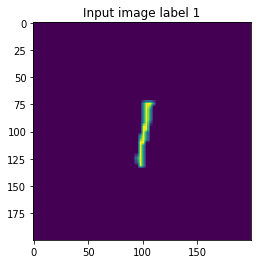

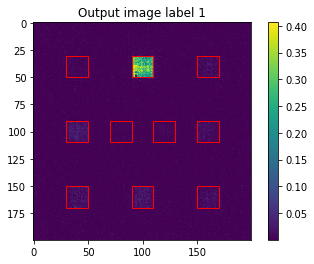

In [ ]:
rand_ind = np.random.choice(range(len(val_dataset)), size=10, replace=False)
for ind in rand_ind:
  visualize(val_dataset[ind])

In [ ]:
def prop_vis_abs(example):
  ex = F.pad(example, pad=(PADDING, PADDING, PADDING, PADDING))
  _, _, imgs = model(ex.to(device))
  for img in imgs:
    plt.imshow(img[0].abs().detach().cpu())
    plt.show()

def prop_vis_phase(example):
  ex = F.pad(example, pad=(PADDING, PADDING, PADDING, PADDING))
  _, _, imgs = model(ex.to(device))
  for img in imgs:
    plt.imshow(img[0].angle().detach().cpu())
    plt.show()

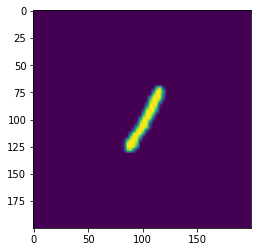

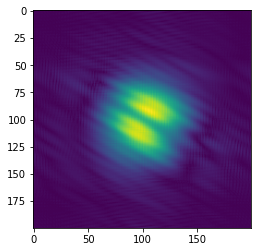

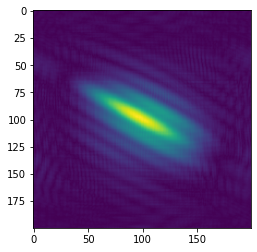

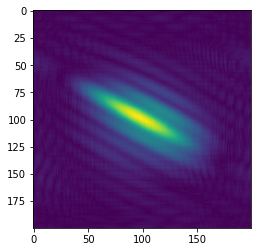

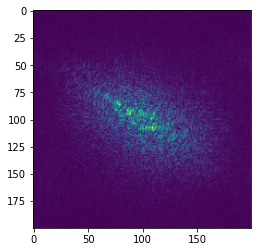

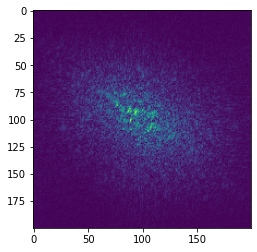

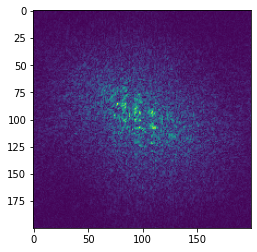

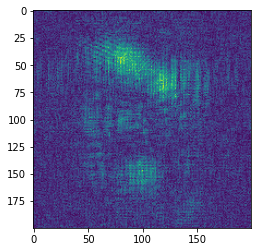

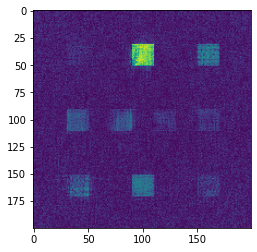

In [ ]:
rand_ind = np.random.choice(range(len(val_dataset)), size=1, replace=False)
prop_vis_abs(val_dataset[rand_ind[0]][0])

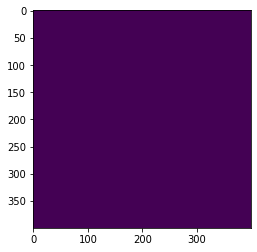

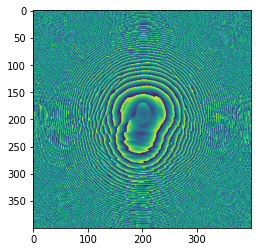

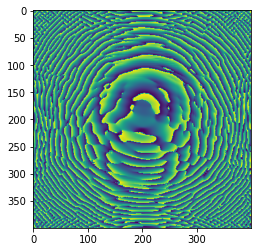

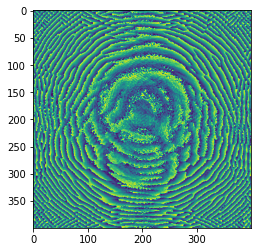

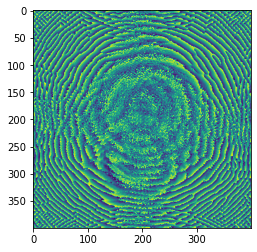

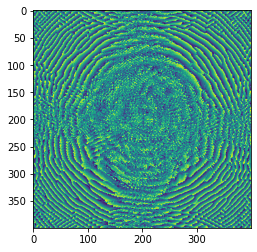

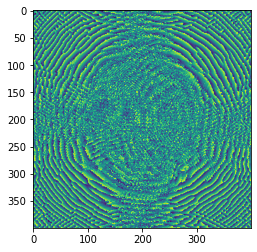

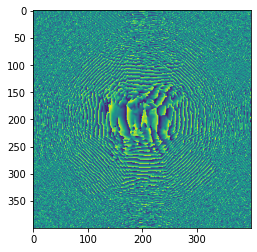

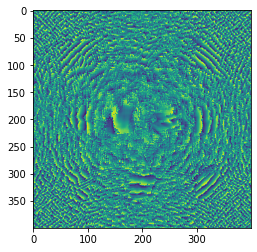

In [ ]:
prop_vis_phase(val_dataset[rand_ind[0]][0])

In [ ]:
a = DiffractiveLayer(wl, N_pixels, pixel_size, 1e-2)

In [ ]:
ex = F.pad(val_dataset[rand_ind[0]][0], pad=(PADDING, PADDING, PADDING, PADDING))

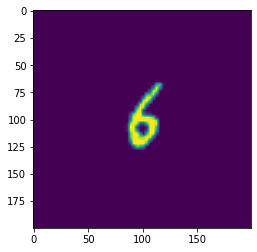

In [ ]:
plt.imshow(ex[0])

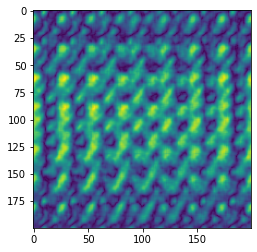

In [ ]:
plt.imshow(a(ex.to(device)).abs().cpu()[0])